In [1]:
from IPython.core.display import HTML
HTML('<style>.container { width:95% !important; }</style>') 

In [33]:
# %matplotlib inline
from matplotlib import pyplot as plt
import re
import seaborn as sns
# import seaborn.apionly as sns


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


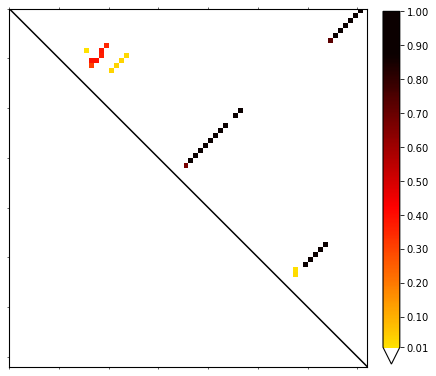

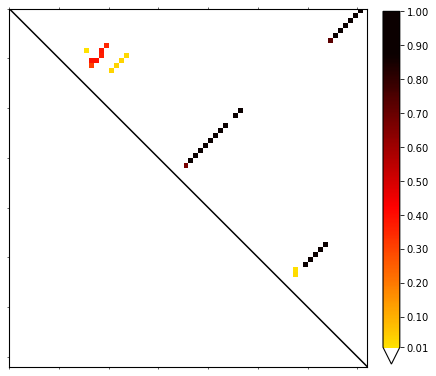

In [8]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
# from local_dotplot_lib import *

import local_dotplot_lib as ldp

plt.rcParams["axes.grid"] = True
plt.rcParams['axes.linewidth'] = 1.1 #set the value globally
plt.rcParams['axes.linewidth'] = 1.1 #set the value globally


trna="GCCUUUUUAGCUCAGUGGUAGAGCAUUGUAUUUGUAAUGCGGUGGUCGUCGGUUCGAAUCCGACAAAAGGCU"

ldp.plot_heat_maps(None, ldp.getBPPM(trna), filename='/tmp/trna', what='basepairs',
                   inverse=True, interactive=False, gene_loc=None)

In [17]:
def walk_basepairs_get_stems(mat, p_thresh=0.5, inner_loop=False):
    bpXs, bpYs = np.where(mat > p_thresh) # Note: hopefully the returned  indices of where are sorted by x values
    bpXs +=1
    bpYs += 1 
    if len(bpXs) == 0:
        #print ("WARNING: No basepair with prob larger than {}".format(p_thresh))
        return {}
        
    # startX: 3'end startY:5'end of the stem
    stem_startX, stem_startY = bpXs[0], bpYs[0]
    stem_endX, stem_endY = bpXs[0], bpYs[0]
    stems_dict = {} 
    stems_list = []
    for x, y in zip(bpXs, bpYs):
        #print '  {}-{},{}-{}'.format(stem_startX,stem_endX, stem_endY, stem_startY)

        #print x,y,
        if ( abs(x-stem_endX) <= 5 and abs(y-stem_endY) <= 5 and
               ((~inner_loop and ( (abs(x-stem_endX) <= 1) or (abs(y-stem_endY) <= 1)))
                or 
                (inner_loop  and ( (abs(x-stem_endX) <= 3) or (abs(y-stem_endY) <= 3)))
               )
               ):
        
            
#             if (abs(x-stem_endX) >= 5) or (abs(y-stem_endY) >= 5):
#                 print "WARNING: bulge of size larger than 5 added at x={}, y={}! ".format(x,y)
                
            stem_endX = x
            stem_endY = y
        else:
            #print " new",
            #print '  {}-{},{}-{}'.format(stem_startX,stem_endX, stem_endY, stem_startY)
            # Validating order of stem indices
            
            assert stem_startX <= stem_endX
            assert stem_endX < stem_endY
            assert stem_endY <= stem_startY
            
            # stem coords as key string
            k = '{}-{},{}-{}'.format(stem_startX,stem_endX, stem_endY, stem_startY)
            # stem length as dict value
            stems_dict[k] = min( (stem_endX-stem_startX)+1 , (stem_startY-stem_endY)+1), stem_endY-stem_endX-1
            
            stem_startX, stem_startY = x, y
            stem_endX, stem_endY = x, y
    
    k = '{}-{},{}-{}'.format(stem_startX,stem_endX, stem_endY, stem_startY)
    #print k, stem_endX-stem_startX , (stem_startY-stem_endY)
    assert k not in stems_dict # It should be the case always..?
    stems_dict[k] = min( (stem_endX-stem_startX+1) , (stem_startY-stem_endY+1)), stem_endY-stem_endX-1 
    
    return stems_dict

import pandas as pd
from Bio import SeqIO
def fasta_to_df(fasta_file, use_dpps_folder=False, add_shuffle=True,add_bpmat=True):
    seq_recs = list(SeqIO.parse(fasta_file, format='fasta'))
    df_fasta = pd.DataFrame(index=[r.id for r in seq_recs])

    df_fasta['sequence'] = [str(s.seq).upper().replace('T','U') for s in seq_recs] 
    do_dinuc_shuf = False
    import random

    if add_shuffle:
        if do_dinuc_shuf:
            df_fasta['sequence-shuffled'] = [dinuclShuffle(s) for s in df_fasta['sequence']]
        else:
            df_fasta['sequence-shuffled'] = [''.join(random.sample(s,len(s))) for s in df_fasta['sequence']]
    if add_bpmat:
        df_fasta['bp-matrix'] = [ldp.getBPPM(s) for s in df_fasta['sequence']]
        if add_shuffle:
            df_fasta['bp-matrix-shuffled'] = [ldp.getBPPM(s) for s in df_fasta['sequence-shuffled']]
    return df_fasta
# walk_basepairs_get_stems(bpmat,inner_loop=True)
# bpXs, bpYs = np.where(bpmat>0.5)
# zip(bpXs, bpYs, bpXs+1, bpYs+1)


In [23]:
def filter_stemsd_list(sdl, max_inner_distance=10, min_stem_length=4):
    sdl_filt = list()
    for sd in sdl:
        #print sd
        sd_filt ={k:sd[k] for k in sd if sd[k][0]>=min_stem_length and sd[k][1]<=max_inner_distance}
        #print sd_filt
        #print
        sdl_filt.append(sd_filt)
    return sdl_filt

from matplotlib_venn import venn2#, venn3_circles
def plot_venn(stems, rangeA = (45,55), rangeB = (73,83), ax=None):
    setinA, setinB = set(), set()

    for ids, sdic in enumerate(stems):
        centers = [int(re.split("\D+", k)[1]) + (int(re.split("\D+", k)[2]) - int(re.split("\D+", k)[1]))/2 for k in sdic]
        inA = 0 < len([c for c in centers if rangeA[0]<=c<=rangeA[1]])
        inB = 0 < len([c for c in centers if rangeB[0]<=c<=rangeB[1]])
        if inA:
            setinA.add(ids)
        if inB:
            setinB.add(ids)
        
    venn2([setinA, setinB], set_labels =['SL-center {}-{}'.format(*rangeA),'SL-center {}-{}'.format(*rangeB)],ax=ax)
    

import numpy as np

def annotate_stems(df, rangeA = (45,55), rangeB = (73,83), ax=None):
    for shufsuffix in ['','-shuffled']:
        stems_nonfilt = [walk_basepairs_get_stems(s) for s in df['bp-matrix'+shufsuffix]]
        stems = filter_stemsd_list(stems_nonfilt)

        filter_stemsd_list
        stemA, stemB = [None]*len(df),[None]*len(df)
        inAarr, inBarr = [False]*len(df),[False]*len(df)
        for ids, sdic in enumerate(stems):
            keys = [k for k in sdic]
            centers = [int(re.split("\D+", k)[1]) + (int(re.split("\D+", k)[2]) - int(re.split("\D+", k)[1]))/2 for k in keys]
            diffs = [int(re.split("\D+", k)[2]) -int(re.split("\D+", k)[1]) for k in keys]
            isinA = [rangeA[0]<=c<=rangeA[1] for c in centers ]
            isinB = [rangeB[0]<=c<=rangeB[1] for c in centers ]
            if  True in isinA:
                if isinA.count(True)>1:
                    print ("Multiple centersA", [k for i,k in enumerate(keys) if isinA[i]])
                    raise(RuntimeError("Multiple centersA"))
                inAarr[ids] = True
                dicdiffs = {keys[i]:d for i,d in enumerate(diffs) if isinA[i]}
                mindif = min(dicdiffs.values())
                stemA[ids] = list(dicdiffs.keys())[list(dicdiffs.values()).index(mindif)]



            if True in isinB:
                if isinB.count(True)>1:
                    print ("Multiple centersB", [k for i,k in enumerate(keys) if isinB[i]])
                    raise(RuntimeError("Multiple centersB"))
                inBarr[ids] = True
                dicdiffs = {keys[i]:d for i,d in enumerate(diffs) if isinB[i]}
                mindif = min(dicdiffs.values())

                stemB[ids] = list(dicdiffs.keys())[list(dicdiffs.values()).index(mindif)]
    #             print stemB[ids], keys, isinB, mindif

        df['stem-inA'+shufsuffix] = stemA
        df['stem-inB'+shufsuffix] = stemB

    return df


    

In [24]:
fa_peakcentered = '../../GalaxyGraphClust/Staufen/Galaxy16-[stau-phastcons20-nomerge-extended100-fixed-centered.fa].fasta' #('../../GalaxyGraphClust/Staufen/Galaxy7-[stau-extended100-fixed-centered.fa].fasta')
mydf_peakcentered = fasta_to_df(fa_peakcentered)
annotate_stems(mydf_peakcentered)

,sequence,sequence-shuffled,bp-matrix,bp-matrix-shuffled,stem-inA,stem-inB,stem-inA-shuffled,stem-inB-shuffled
hg19_chr1_1716777_1716877_-,ACAACUCUGUAGAGCUCUCUGCACCCUUACCCCUUUCCACCUUUUG...,GGUGAACCUAAUUGUUCACACCGUGGUCUCUUGCCCAAAGAAAAAC...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 6.862924004257899e-...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.672690192946...",None,None,"36-43,52-59",None
hg19_chr1_1716798_1716898_-,CCUUCUUUCUCUUUCCGUCCAACAACUCUGUAGAGCUCUCUGCACC...,AUUCCGUGGCGGAAGAUAACUACUCUCCCCCAUAUUUUAUACUGAC...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.000117368248...",None,"70-73,78-81",None,None
hg19_chr1_1716898_1716998_-,GUAGUGGCUUCUCCAUCCUGUUUUCUGCAACAUUCUAUACAAAACU...,UGCUCGUUCGUAUAGAGCAGCUAGCUGCUACAGAUCUGGAAGUCCG...,"[[0.0, 0.0, 0.0, 0.0, 2.4803236913183076e-06, ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 6.256325193459149e-...",None,None,None,None
hg19_chr1_1716914_1717014_-,CUCCUUCAUAGCAGCAGUAGUGGCUUCUCCAUCCUGUUUUCUGCAA...,GACGACUGAAAUUCCAAUUUCGUGCUGUCACUCUAGUCUCUAUAGC...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 1.9750828023860512e...",None,None,None,None
hg19_chr1_1717265_1717365_-,GCGGCUCUGUCCACUUCUCGUUGCUGCUCUGUGGCACAUAUCGGAA...,GGCUGCAAACUUCACGUACGUUUCGCGGAAUCUGGGAUCCGGACCG...,"[[0.0, 0.0, 0.0, 0.0, 2.0310264317480804e-06, ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 1.3216506820004232e...",None,None,None,None
...,...,...,...,...,...,...,...,...
hg19_chrX_154467254_154467354_+,UAUUUAUAAAAACAAAAUUAGUUUCAAAUAUUUUUGACAUUGUGAU...,AUAAUUAUUUGAACUUCUCAUUAUAUGUUUCAUUAACUCUAUGACU...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.00020348165395655...","[[0.0, 0.0, 0.0, 0.0, 2.237671064267588e-05, 0...",None,None,None,None
hg19_chrX_155172786_155172886_+,CAUCUGUUAUCUAGUAUGCAUUUCUGGUGUGUAUCUGAAAGGAAGA...,GUGCCCUAUCCAUAAGAAGAGUCUAGUUACUUCACUAUUAAUUUAU...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.00167613344442802...","[[0.0, 0.0, 0.0, 0.0, 0.0005086959396638252, 0...",None,"70-78,83-91",None,None
hg19_chrX_155173170_155173270_+,CCUAUUGGAAAAUACAUCUGUUCCAGAAAAACAUUUGGCAUUCCUG...,UACGGGAAAUAAAUAAUUAAGCAUUUUCAGAUAUUUUAUUAAUCUA...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.444425482752...","[[0.0, 0.0, 0.0, 0.0, 7.412670936575623e-07, 3...",None,None,None,None
hg19_chrX_155173188_155173288_+,UGUUCCAGAAAAACAUUUGGCAUUCCUGAAUAAUUUCCAAAUGUUU...,AAAAAGACUCUCUAGUUGUAAUGCCCCGUGUUUAUAAAGUUUAAUA...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.002008563005...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.02...",None,None,None,None


In [26]:
def select_stems_by_loc(df,  max_inner_distance=10, min_stem_length=7,AB_char='A'):
    
    assert (AB_char=='A' or AB_char=='B')
    df_with_stem = df[df['stem-in'+AB_char].notnull()]
    df_stems_info = df_with_stem['stem-in'+AB_char].str.split("\D+",expand=True).astype(int) #.loc[:,0]
    df_stems_info.rename(columns={0:'stem0', 1:'stem1',2:'stem2',3:'stem3'}, inplace=True)
    df_stems_info = pd.merge(df_with_stem, df_stems_info,left_index=True, right_index=True)
    if min_stem_length>0:
        df_stems_info = df_stems_info[(df_stems_info['stem1']-df_stems_info['stem0']+1)>=min_stem_length]
    if max_inner_distance>0:
        df_stems_info = df_stems_info[(df_stems_info['stem2']-df_stems_info['stem1']-1)<=max_inner_distance]
    return df_stems_info
def df_to_fasta(df, outfasta):
    with open (outfasta,'w') as outfa:
        outfa.write('\n'.join('>'+df.index.astype(str) +  '\n'+ df['sequence'].astype(str)))
    print('fasta saved:',outfasta)

# df_stem_info
# sd_filt ={k:sd[k] for k in sd if sd[k][0]>=min_stem_length and sd[k][1]<=max_inner_distance}
select_stems_by_loc(mydf_peakcentered,min_stem_length=5,max_inner_distance=12)

,sequence,sequence-shuffled,bp-matrix,bp-matrix-shuffled,stem-inA,stem-inB,stem-inA-shuffled,stem-inB-shuffled,stem0,stem1,stem2,stem3
hg19_chr1_1717347_1717447_-,AAAUGCUCAAAAGUGCAUAUGGGACUCAGUCCUUAGGUGUUCUUUU...,UCCUGUAGCUCGUUGUAUUGUAUCUUAAUAACUUGCCUAGGUUCUG...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.106760474389...","[[0.0, 0.0, 0.0, 0.0, 5.025510636471468e-07, 0...","40-44,53-57","70-76,82-88",None,None,40,44,53,57
hg19_chr1_1717900_1718000_-,UCCUUUGUGUUCAACAGUUAAUCAAAACCAGAGAGUCUAGGGCAGC...,ACUCAUGAUCCGACUAGAUCUUUGUAGCACUCAAUACGGAAUUCUC...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 9.577467553466...","[[0.0, 0.0, 0.0, 0.0, 0.0, 7.2403448680551e-05...","41-46,56-61",None,None,None,41,46,56,61
hg19_chr1_16721966_16722066_+,CAGUGCCAGCAAUAACAGUUUAUCAUGCUCAUUAAUUUGGGAUUUC...,AACUUCCCACACACCGGCUAAAAUCCAAUAAUUCCACAAGAUUAAA...,"[[0.0, 0.0, 0.0, 0.0, 8.748621065453506e-05, 0...","[[0.0, 0.0, 0.0, 0.0, 3.6242531780428614e-05, ...","43-47,57-61",None,None,None,43,47,57,61
hg19_chr1_21546020_21546120_-,GAUAUAUUUUUGGGGAAACUAUUUUUUAAACACUGUGGAAUACACU...,UGAGUUAUCACCUAGUUAAAUAUUGUCAGAAUUAUUUAUUCAGAAG...,"[[0.0, 0.0, 0.0, 0.0, 8.768034791870308e-05, 0...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 6.454469433236...","45-49,54-58",None,None,None,45,49,54,58
hg19_chr1_22418459_22418559_+,UGUGUGGGGUUUGUUUUUUAGUCUUGUUUUUUUAAUUCAUUAACCA...,CGGUGUAUGGAUUUGUCCAUUAUUAGUUACUAUUGAAUGGCUCGGG...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 2.4007574257571445e...","[[0.0, 0.0, 0.0, 0.0, 9.274383788129671e-05, 0...","40-45,49-54",None,None,None,40,45,49,54
...,...,...,...,...,...,...,...,...,...,...,...,...
hg19_chrX_131338709_131338809_-,GAUAUUGUAUCCAUGGUAAAUUAAUUGUAUACCUAAACAGAGAUAG...,AGUCGCUAUGAUUUCAAGUAUGACUCCCAAUGGCAGAGUAGGCUGU...,"[[0.0, 0.0, 0.0, 0.0, 1.921776964128352e-05, 0...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.000292923585...","38-44,50-56",None,None,None,38,44,50,56
hg19_chrX_133561605_133561705_+,CAGUUGAUGAAUUUGUUAUGUAGUAAAAUGUAUGACUUUGUAUGGG...,UAUUUUGGACAGAAUUCGAUGUGGAACCUUGUGCCUUUAGAUAUAU...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.00396025889499886...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.000552676018...","44-48,54-58",None,None,None,44,48,54,58
hg19_chrX_149841282_149841382_+,UAUUUAUAACUAAUAUGGUUUUGUUUUCAAUGAAUUAAGAAAGAUU...,UUUACAUUAUGUUUGAAUUCUAAUUUAUAUUAUUAUACUAUGUAUC...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.00014064523402544...","[[0.0, 0.0, 0.0, 0.0, 0.0, 8.068977252941274e-...","40-45,53-58",None,None,None,40,45,53,58
hg19_chrX_153213168_153213268_-,CAGCAGCCUGUGUCCUCCAGGGCCUCUGGUUUGUUGUAUUAUAGUA...,GGAUUCAUGUCUCUAAGUUCACUACGAGGCUGCUCGGGCGUUGAUU...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 3.513024708373647e-...","[[0.0, 0.0, 0.0, 0.0, 6.086864859016062e-06, 0...","40-45,53-58",None,None,None,40,45,53,58


In [27]:
mydf_peakcentered_steminA = select_stems_by_loc(mydf_peakcentered,min_stem_length=5,max_inner_distance=12)
fa_peakcentered_stemA = fa_peakcentered+'.with-stemA.fa'
df_to_fasta(mydf_peakcentered_steminA,fa_peakcentered_stemA)

fasta saved: ../../GalaxyGraphClust/Staufen/Galaxy16-[stau-phastcons20-nomerge-extended100-fixed-centered.fa].fasta.with-stemA.fa


In [28]:
mydf_peakcentered_steminB = select_stems_by_loc(mydf_peakcentered,min_stem_length=5,max_inner_distance=12,AB_char='B')
fa_peakcentered_stemB = fa_peakcentered+'.with-stemB.fa'
df_to_fasta(mydf_peakcentered_steminB,fa_peakcentered_stemB)

fasta saved: ../../GalaxyGraphClust/Staufen/Galaxy16-[stau-phastcons20-nomerge-extended100-fixed-centered.fa].fasta.with-stemB.fa


In [15]:
mydf_peakcentered_steminB

,sequence,sequence-shuffled,bp-matrix,bp-matrix-shuffled,stem-inA,stem-inB,stem-inA-shuffled,stem-inB-shuffled,stem0,stem1,stem2,stem3
hg19_chr1_1717347_1717447_-,AAAUGCUCAAAAGUGCAUAUGGGACUCAGUCCUUAGGUGUUCUUUU...,AGUCAGACACAAUCUAUUUCUACUUUCCUAAUAAUGUAUAGCCAAU...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.10676047439e...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","40-44,53-57","70-76,82-88","43-49,54-60","73-76,80-83",70,76,82,88
hg19_chr1_2240950_2241050_+,AGAAACUCUUUUCUUACCUGAGAGUUGUCUUGUUUUCUGGGCUGUU...,UCUGGUGCACCUGACUAUAAGGAGAUUAUAGUUAGCAUCGUGAUAA...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.000504258766...","[[0.0, 0.0, 0.0, 0.0, 8.21653544489e-07, 0.0, ...",None,"69-79,84-95",None,"69-79,84-95",69,79,84,95
hg19_chr1_2241294_2241394_+,CCCGGCCCCCCCACCCCUCCCUCAGCCCACCAGGGUCCAGGGAGAU...,CCGUCACGUCGUAGUUACUGCGCUAUACCGCUCCCCGGCCUGUAGC...,"[[0.0, 0.0, 0.0, 0.0, 6.17297444128e-05, 0.0, ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 5.0947506...",None,"68-74,79-85",None,None,68,74,79,85
hg19_chr1_11114752_11114852_-,CAGCCCCGGGCCGGACCUCCUGCUGGCUCUCGCCCACCAACCAAGU...,CUCCAUCCGCAGUCCAGUACCCAUGUUGCAUCGCCCGCGGUACAGA...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0001262...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 4.49...",None,"64-73,81-91",None,"66-71,80-87",64,73,81,91
hg19_chr1_16722312_16722412_+,AGGGGCAGGGCUCUGCAGCCGCCAGGACAGACGAGCACCCCAUGCC...,CCGGCCGGCCUGCAAGUUGCGCACCGAAACCACGGCUGCCGUGUCA...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.002560409960...",None,"71-75,81-85",None,None,71,75,81,85
hg19_chr1_21070187_21070287_-,UGCCUGGCCUAUCCCACUUGGUUUUUGACUGAAGGGGAAGUGUAGA...,AACUGCUAAAAUAAUUCUUAUGGUGGAAUGGAUCGCGAAUUUUGAU...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 6.18842722967e-05, ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.000289141214...",None,"68-72,83-87",None,None,68,72,83,87
hg19_chr1_22418245_22418345_+,UUUUUUUGUUGUUUCAAAAAAAAAAUUUUUGUGUGUGUGUGUUUUU...,GGUGGUUUAUCUGGUUUUUUAUUUUGCUUUUUGUUAUAAGUUGGAA...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0002557...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.000224546194028, ...",None,"71-75,81-85",None,None,71,75,81,85
hg19_chr1_23884646_23884746_-,UGUGGCCUGAAGAGCCAGAGCUAGCUCUGGCCACCAGCUGGGCGAC...,AGCACGCCAGCCCAUUGGUCAUAGCGCUCAGAGGCGCGCCCCGCGC...,"[[0.0, 0.0, 0.0, 0.0, 7.78938894897e-08, 0.0, ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",None,"74-81,86-94",None,"53-71,80-91",74,81,86,94
hg19_chr1_26227224_26227324_-,GUGUUUUACUCUUUUUCUAAAGUGUUGGUCUUUCUAAUGUAGCUAU...,UUUAUUGGUGCCAUUUUAGUUGGUGAAAGUUACAAUUUCCAUCGCG...,"[[0.0, 0.0, 0.0, 0.0, 2.46601686446e-05, 0.000...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.000514032708...","37-43,54-60","71-79,83-91","41-44,52-55",None,71,79,83,91
hg19_chr1_26227258_26227358_-,UGUUGUUUUAGGGGCUAAAGGGGAGAAACUGAAAGUGUUUUACUCU...,AUUUCACGGUUUUUUUACCAAGGAUCUUUUAACUGAGAUGUUCUUG...,"[[0.0, 0.0, 0.0, 0.0, 7.30443040154e-05, 0.0, ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",None,"71-77,88-94",None,"62-71,80-90",71,77,88,94


In [29]:
! head $fa_peakcentered_stemA

>hg19_chr1_1717347_1717447_-
AAAUGCUCAAAAGUGCAUAUGGGACUCAGUCCUUAGGUGUUCUUUUUCUUUUAAGAAAUAACCUCUUACAGUUGUAACCAUUGCGGCUCUGUCCACUUCU
>hg19_chr1_1717900_1718000_-
UCCUUUGUGUUCAACAGUUAAUCAAAACCAGAGAGUCUAGGGCAGCCUCUCUGAUGUUGUCAAUGAUGUAAAUUCAGUCCCUGGUUUUUAAUUUUCUGUC
>hg19_chr1_16721966_16722066_+
CAGUGCCAGCAAUAACAGUUUAUCAUGCUCAUUAAUUUGGGAUUUCAAAACACAAAUGAAAACUCACACCCACCCACCCCCAAGUGCAUGUCUCCAUCAC
>hg19_chr1_21546020_21546120_-
GAUAUAUUUUUGGGGAAACUAUUUUUUAAACACUGUGGAAUACACUGGAAAUCUUCAGGGAAAAACACAUUUAAACACUUUUUUUUUUAAGGAAAGAAUU
>hg19_chr1_22418459_22418559_+
UGUGUGGGGUUUGUUUUUUAGUCUUGUUUUUUUAAUUCAUUAACCAGUGGUUAGCCCUUAAGGGGAGGAGGACGGAUUGAUUCCACAUUCCACUUCCUAG


Fig saved to  ../../GalaxyGraphClust/Staufen/Galaxy16-[stau-phastcons20-nomerge-extended100-fixed-centered].*
Fig saved to  ../../GalaxyGraphClust/Staufen/Galaxy16-[stau-phastcons20-nomerge-extended100-fixed-centered.shuffled].shuffled.*


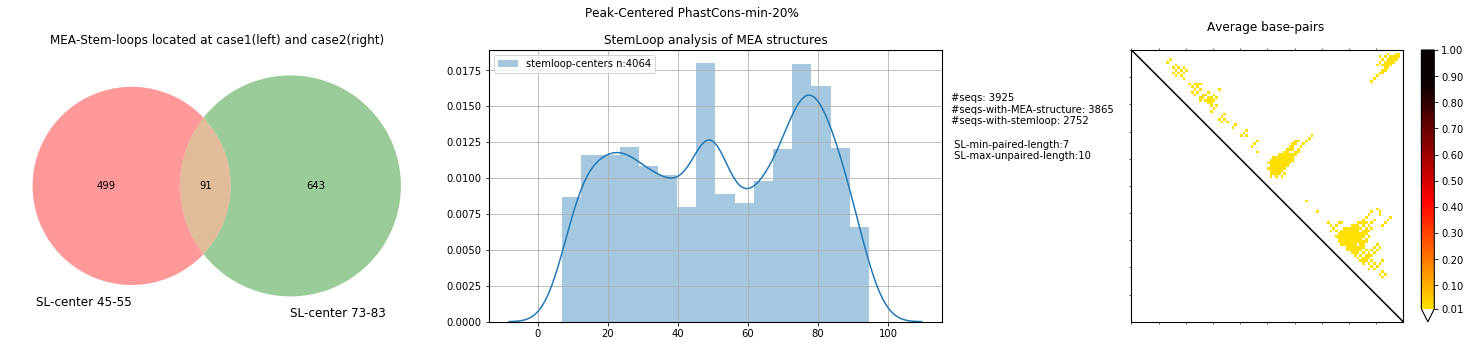

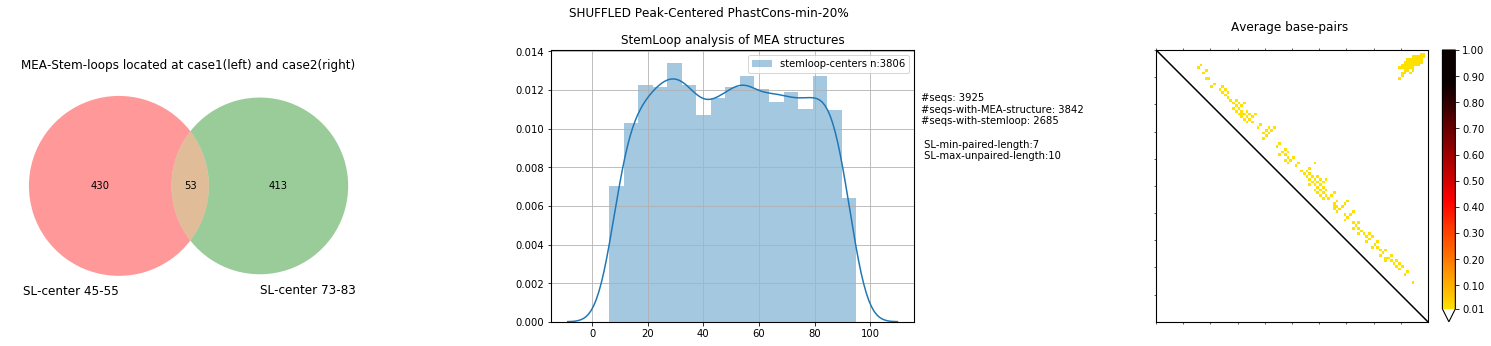

In [34]:
def plot_stems_loc(stemdl_nonfilt, title='',filt=False, max_inner_distance=10, min_stem_length=7, venn=True,rangeA = (45,55), rangeB = (73,83),axes=None):
    if filt is True:
        stemdl = filter_stemsd_list(stemdl_nonfilt)
    else:
        stemdl = stemdl_nonfilt
    if axes is None:
        fig, axes = plt.subplots(ncols=2,figsize=(12,5))
    #starts = [ int(re.split("\D+", k)[1]) for sd in stemdl for k in sd  if len(sd)>0 ]
    #sns.distplot(starts, ax=ax,label='starts')
    #ends = [ int(re.split("\D+", k)[2]) for sd in stemdl for k in sd  if len(sd)>0 ]
    #sns.distplot(ends,ax=ax,label='ends')
    
    centers = [ int(re.split("\D+", k)[1]) + (int(re.split("\D+", k)[2]) - int(re.split("\D+", k)[1]))/2 for sd in stemdl for k in sd  if len(sd)>0 ]
    #print centers
    sns.distplot(centers,ax=axes[1],label='stemloop-centers n:{}'.format(len(centers)))
    axes[1].legend()
    axes[1].annotate(#xytext = (0.4, 0.4),
                     xy=(1.02,.6),
                     xycoords='axes fraction',
                     s=             '#seqs: {}\n#seqs-with-MEA-structure: {}\n#seqs-with-stemloop: {}\n\n SL-min-paired-length:{}\n SL-max-unpaired-length:{}   '.format(len(stemdl_nonfilt), 
                                                                                  len([sd for sd in stemdl_nonfilt if len(sd)>0]),
                                                                                  len([sd for sd in stemdl if len(sd)>0]),
                                                                                  min_stem_length,max_inner_distance
                                                                                                                          ),
#             horizontalalignment='left',
                )
    
    axes[1].set_title('StemLoop analysis of MEA structures')
    if venn is True:
        plot_venn(stemdl,ax=axes[0],rangeA=rangeA, rangeB=rangeB)
        axes[0].set_title('MEA-Stem-loops located at case1(left) and case2(right)')

#     fig.suptitle(title + '\nStemLoop analysis of MEA structures\n'                , y=1.0)
    
def analyze_df(df, filename,title='',average=True, walk_stems=True, venn=True, filt=False,rangeA = (45,55), rangeB = (73,83)):
    
    axes=None
    if average:
        fig, axes= plt.subplots(ncols=3,figsize=(26,5))
        fig.suptitle(title , y=1.0)
        fig.subplots_adjust(wspace=.1)
        
        figshuf, axesshuf= plt.subplots(ncols=3,figsize=(26,5))
        figshuf.suptitle('SHUFFLED ' + title , y=1.0)
        figshuf.subplots_adjust(wspace=.5)
        
        average_bpmat = np.average(df['bp-matrix'])
        average_bpmat_shuff = np.average(df['bp-matrix-shuffled'])
        
        fig_file =  filename.replace('fasta','fa').replace('.fa','')
        fig_file_shuff = filename.replace('fasta','fa').replace('.fa','.shuffled')
        #fig= plt.figure(figsize=(12,5))#subplots(ncols=2,figsize=(12,5))

        ldp.my_heatmap(average_bpmat, fig,axes[2], 
                   inverse=True, interactive=False, gene_loc=None,title='Average base-pairs ')
        ldp.my_heatmap( average_bpmat_shuff,figshuf,axesshuf[2],
                   inverse=True, interactive=False, gene_loc=None, title='Average base-pairs ')
        
    if walk_stems:
        stems = [walk_basepairs_get_stems(s) for s in df['bp-matrix']]
        plot_stems_loc(stems,venn=venn, filt=filt,title=title,axes=axes[:],rangeA=rangeA, rangeB=rangeB)
        #plt.show()
        stems_shuf = [walk_basepairs_get_stems(s) for s in df['bp-matrix-shuffled']]
        plot_stems_loc(stems_shuf,venn=venn,filt=filt,title= title + ' SHUFFLED',axes=axesshuf[:], rangeA=rangeA, rangeB=rangeB)
        #plt.show()
    fig.savefig(fig_file+'.pdf',bbox_inches='tight')
    figshuf.savefig(fig_file_shuff+'.pdf',bbox_inches='tight')
    fig.savefig(fig_file+'.svg',bbox_inches='tight')
    figshuf.savefig(fig_file_shuff+'.svg',bbox_inches='tight')
    
    print ("Fig saved to " , fig_file+".*")
    print ("Fig saved to " , fig_file_shuff+".*")
    
       
analyze_df(mydf_peakcentered,fa_peakcentered,title='Peak-Centered PhastCons-min-20%',average=True,walk_stems=True,filt=True)

Fig saved to  ../../GalaxyGraphClust/Staufen/Galaxy16-[stau-phastcons20-nomerge-extended100-fixed-centered].*
Fig saved to  ../../GalaxyGraphClust/Staufen/Galaxy16-[stau-phastcons20-nomerge-extended100-fixed-centered.shuffled].shuffled.*


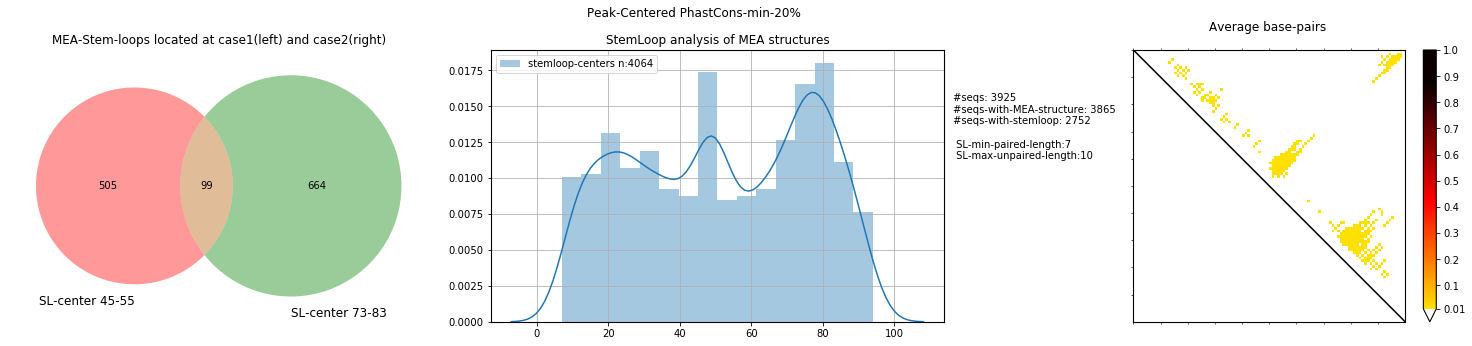

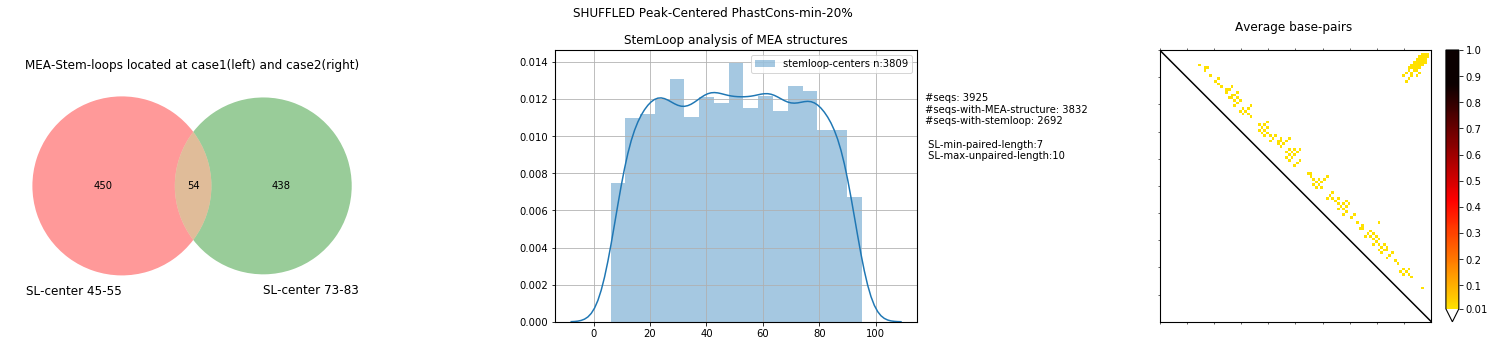

Fig saved to  ../../GalaxyGraphClust/Staufen/Galaxy21-[stau-phastcons20-nomerge-extended200-fixed-centered].*
Fig saved to  ../../GalaxyGraphClust/Staufen/Galaxy21-[stau-phastcons20-nomerge-extended200-fixed-centered.shuffled].shuffled.*


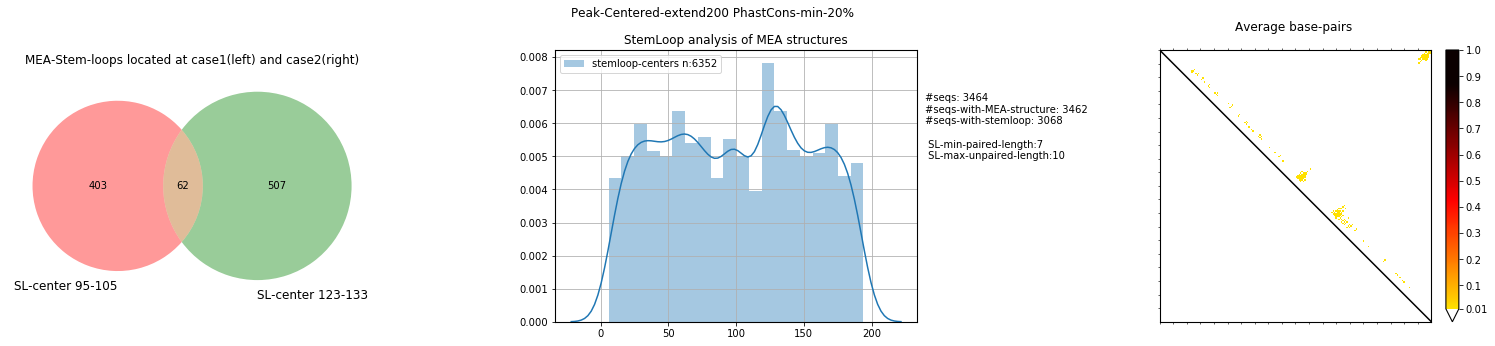

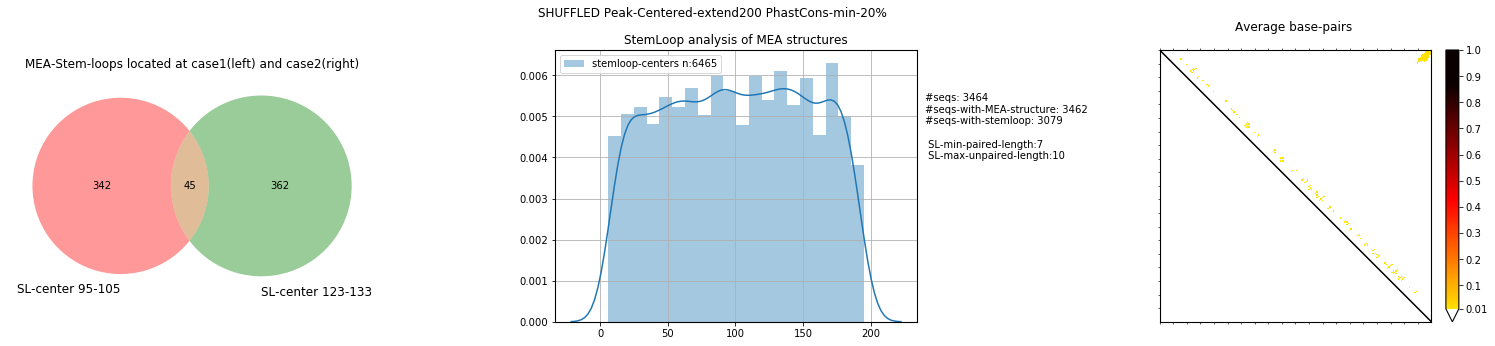

In [96]:
# fa_peakcentered200 = '../../GalaxyGraphClust/Staufen/Galaxy21-[stau-phastcons20-nomerge-extended200-fixed-centered.fa].fasta'
# mydf_peakcentered200 = fasta_to_df(fa_peakcentered200)
# annotate_stems(mydf_peakcentered200,rangeA=(95,105),rangeB=(123,133))


analyze_df(mydf_peakcentered200,fa_peakcentered200,title='Peak-Centered-extend200 PhastCons-min-20%',average=True,walk_stems=True,filt=True,rangeA=(95,105),rangeB=(123,133))

In [37]:
def extract_stem_seqs(df,target='stem-inA',pad=0,downup_stream=0,full_seq=False):
    
    df_A = df[df[target].notnull()]
    if full_seq is True:
        with open('./phastcos20-peakcentered-stemB100-fullseq200.fa','w') as outfa:
            outfa.writelines(['>{}\n{}\n'.format(i,s) for i,s in df_peakcentered200_stemA100['sequence'].to_dict().items() if len(s)>=8])
        return df_A['sequence'].to_dict()
    seqsA_dic = dict()
    seqsAUP_dic =dict()
    for index, row in df_A.iterrows():
        #print row['sequence'], row['stem-inA']
        if downup_stream != 0:
            assert pad == 0
            if downup_stream < 0:
                cut_range = (int(row[target].split('-')[0])+downup_stream, int(row[target].split('-')[0]))
            else:
                cut_range = (int(row[target].split('-')[2])+1 , int(row[target].split('-')[2])+1+downup_stream)
        else:
            cut_range = (int(row[target].split('-')[0])-pad, int(row[target].split('-')[2])+1+pad)
                
        seqsA_dic[index] = row['sequence'][cut_range[0]:cut_range[1]]
#             int(row['stem-inA'].split('-')[0])-pad+shift: int(row['stem-inA'].split('-')[0])-pad
#             int(row['stem-inA'].split('-')[2])+1-pad: int(row['stem-inA'].split('-')[2])+1-pad+shift
                                          # int(row['stem-inA'].split('-')[2])+1+pad+shift
#                                           ]#.str.slice(df_A.head()['stem-inA'].str.split('-').str[0].astype(int), df_A.head()['stem-inA'].str.split('-').str[2].astype(int))
        if len(seqsA_dic[index]) < 8:
            print ("Warning sequence length less than 8 for ", index)
        seqsAUP_dic[index] = row['sequence'][int(row[target].split('-')[1].split(',')[0]): 
                                           int(row[target].split('-')[1].split(',')[1])+1]
    with open('./phastcos20-peakcentered-stemsB-downstream20.fa','w') as outfa:
        outfa.writelines(['>{}\n{}\n'.format(i,s) for i,s in seqsA_peakc.items() if len(s)>=8])

    with open('./phastcos20-peakcentered-stemsB-Unpaired.fa','w') as outfa:
        outfa.writelines(['>{}\n{}\n'.format(i,s) for i,s in unpaired_peakc.items() if len(s)>=8])
    #return seqsA_dic, seqsAUP_dic

extract_stem_seqs(mydf_peakcentered,target='stem-inA',pad=0,downup_stream=0)
# fullseqsB = extract_stem_seqs(mydf_peakcentered,target='stem-inB',full_seq=True)

NameError: name 'seqsA_peakc' is not defined

In [167]:
keys100to200 = ['{}_{}_{}_{}_{}'.format(k.split('_')[0],k.split('_')[1],int(k.split('_')[2])-50,int(k.split('_')[3])+50,k.split('_')[4]) for k in seqsAB_peakc ]
df_peakcentered200_stemA100 = mydf_peakcentered200[mydf_peakcentered200.index.isin(keys100to200)]

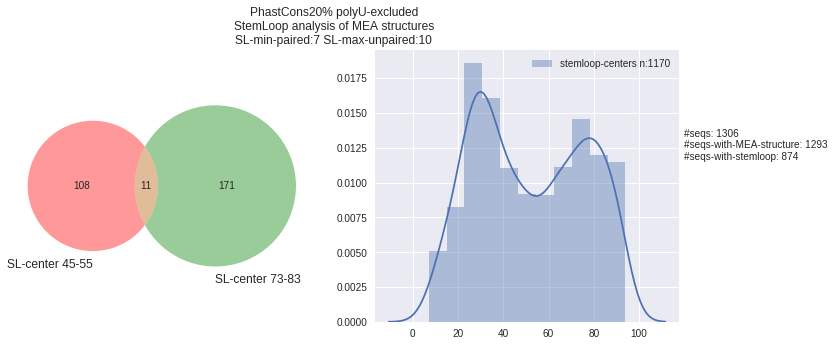

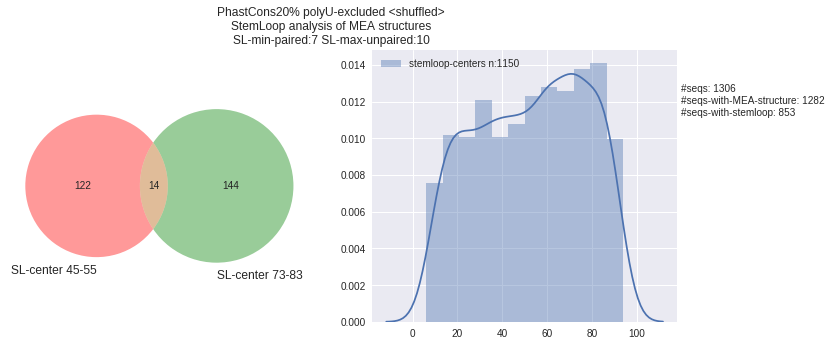

In [276]:
mydf_peakcentered = fasta_to_df('../../GalaxyGraphClust/Staufen/Galaxy7-[stau-extended100-fixed-centered.fa].fasta')
analyze_df(mydf_peakcentered,'stau-extended100-fixed-centered.fa',title='peak-centered',filt=True)

# analyze_df(mydf[mydf['sequence'].str[:20].str.upper().str.count('U')<10]
#            , fasta_phast20, average=False,walk_stems=True)
analyze_df(mydf[mydf['sequence'].str[:20].str.upper().str.count('U')<10]
           , fasta_phast20, title='PhastCons20% polyU-excluded',average=False,walk_stems=True,filt=True,)
